In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

Since ACT is a standardized test and standards for graduation rates vary across schools, we performed the majority of our regression treating ACT scores as the dependent variable corresponding to school success. We performed a regression treating the 2021 ACT data as an independent variable and the 2022 data as a dependent variable and found that the coefficient value was 0.89 even with no other control variables (besides a constant). If we weight by the number of juniors and seniors at the school then the coefficient increases to 0.999 - so the schools with the most consistent scores are the larger ones, which is what we would expect. This means that the prior year's average ACT score is an excellent predictor of how a school will perform this year. Because of this, we concluded that average ACT scores are mostly independent of what specific students are taking the test, and highly dependent on the school the students go to. Furthermore, we concluded that using the 2022 ACT data alone as the dependent variable was a valid measure of school success. Visual representations below show that the spread of ACT scores in the sample is significant and somewhat bell shaped, as well as the persistence of ACT scores from year to year. 

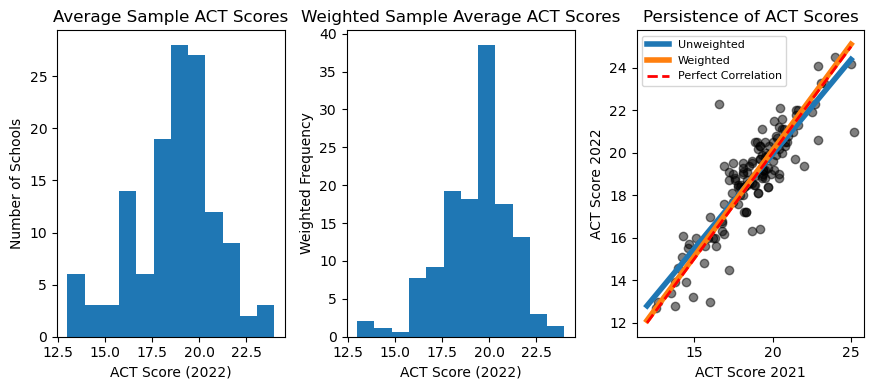

In [2]:
#Make a histogram of ACT scores
data = pd.read_csv('cleaned_with_salaries.csv')
weights = data['students_11_12'] / data['students_11_12'].mean()
act22 = np.round(data['act22'])
fig, [ax, ax2, ax3] = plt.subplots(figsize=(9,4), nrows=1, ncols=3)
act22.plot(kind='hist', bins=12, grid=False, ax=ax)
act22.plot(kind="hist", weights=weights, ax = ax2, bins=12) #Weighted by School Size
ax.set_title("Average Sample ACT Scores")
ax.set_xlabel("ACT Score (2022)")
ax.set_ylabel("Number of Schools")
ax2.set_title("Weighted Sample Average ACT Scores")
ax2.set_xlabel("ACT Score (2022)")
ax2.set_ylabel("Weighted Frequency")
plt.tight_layout()

#Regression of past year ACT on this year ACT
X = data['act21'].values.reshape(-1,1)
y = data['act22'].values.reshape(-1,1)
act_reg_model = LinearRegression().fit(X, y) #Unweighted Model
beta, intercept = act_reg_model.coef_, act_reg_model.intercept_
act_reg_model.fit(X, y, weights) #Weighted Model
beta2, intercept2 = act_reg_model.coef_, act_reg_model.intercept_
domain = np.linspace(12, 25, 100)
ax3.scatter(data['act21'], data['act22'], color='black', marker='o', alpha=0.5) #Persistence Graph
ax3.plot(domain, intercept[0]+beta[0]*domain, lw=4, label='Unweighted')
ax3.plot(domain, intercept2[0]+beta2[0]*domain, lw=4, label='Weighted')
ax3.plot(domain, domain, '--', lw=2, label='Perfect Correlation', color='red')
ax3.set_xlabel("ACT Score 2021")
ax3.set_ylabel("ACT Score 2022")
ax3.set_title("Persistence of ACT Scores")
ax3.legend(fontsize=8)
plt.show()

In all models we weighted by the student population in order to prioritize larger schools since they had more students that took the test. Moreover, they are of greater interest since they represent the majority of students. This also helps to produce more reasonable results, since the smallest schools tend to have unusually high or low ACT scores since many of them are more specialized in nature. Our first pass at the data involved using OLS and manually evaluating which features seemed to be important as well as how predictive our data was. The results are below.

In [3]:
#Regression with many different features
y = data['act22'].values
X = data[['meanschooladministratorsalaryind','administratortoteachermeansalary', 'meanteachersalaryindollars',
       'log_students', 'attendance21','attendance22', 'americanindian_2022_p','afamblack_2022_p', 'asian_2022_p', 
          'hispanic_2022_p', 'multiplerace_2022_p', 'pacificislander_2022_p', 'totalk12_2022', 'grade_9_2022', 
        'grade_10_2022', 'grade_11_2022', 'grade_12_2022', 'female_2022_p','economicallydisadvantaged_2022_p', 
          'englishlearner_2022_p', 'studentwithadisability_2022_p','homeless_2022_p', 'charter']]
X = X.fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(weights=weights)
#print(model.summary(slim=True))
print("MSE:", mean_squared_error(model.predict(X), y), "AIC:", model.aic, "BIC:", model.bic, "R2", model.rsquared)

MSE: 1.3587168642043812 AIC: 463.06315469456166 BIC: 532.2504008366345 R2 0.7702893171776053


The above regression suggests that many of the variables we have are not very relevant in predicting a school's average ACT score. Although none of the columns are strictly collinear, including all of these variables does introduce a number of columns that are nearly multicollinear (such as attendance in 2021 and 2022), which undoubtadly overfits the model and produces bad estimates for beta. The following variables seem as if they are not aiding in our predictions: teacher salaries, log number of students, detailed breakdown of school size, percent female (Based on p values, not shown, but available by uncommenting print model summary). If we remove those variables we get the model in the next panel. 

In [4]:
#Regression with further reduced data
y = data['act22'].values
X = data[['americanindian_2022_p',
       'afamblack_2022_p', 'asian_2022_p', 'hispanic_2022_p', 'multiplerace_2022_p', 'pacificislander_2022_p',
          'totalk12_2022', 'economicallydisadvantaged_2022_p', 'englishlearner_2022_p', 
          'studentwithadisability_2022_p','homeless_2022_p', 'charter']]
X = X.fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(weights=weights)
#print(model.summary(slim=True))
print("MSE:", mean_squared_error(model.predict(X), y), "AIC:", model.aic, "BIC:", model.bic, "R2", model.rsquared)

MSE: 1.5467341284974265 AIC: 458.17100439803477 BIC: 495.64742939165757 R2 0.7385022868543712


This model has nearly the same R Squared value as the previous one, and improved AIC and BIC scores. Almost all of the features appear to be statistically significant, with the exception of pacificislander proportion, total number of students, and possibly proportion economically disadvantaged. Essentially what this indicates is that, given the available data, predictions made just on the racial proportions of a school seem to predict the average ACT score perform just as well as regressions that include more features. To test that, we include a regression using only the racial breakdown in the next panel. 

In [5]:
#Regression with Racial Breakdown
y = data['act22'].values
X = data[['americanindian_2022_p','afamblack_2022_p', 'asian_2022_p', 'hispanic_2022_p', 'multiplerace_2022_p', 'pacificislander_2022_p']]
X = X.fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(weights=weights)
#print(model.summary(slim=True))
print("MSE:", mean_squared_error(model.predict(X), y), "AIC:", model.aic, "BIC:", model.bic, "R2", model.rsquared)

MSE: 3.089761168604464 AIC: 537.5081538655859 BIC: 557.6877673236904 R2 0.4776313104688974


However, in this model we see a sharp drop in R Squared and a substantial rise in AIC, BIC, and MSE - so clearly some of the other features were actually important in making predictions, and forcasting ACT scores just based on racial demographics is a mistake. In subsequent sections we will explore other approaches such as Ridge and Lasso to identify a good model for the data. 